In [3]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 17 15:04:13 2018
Decision Tree

@author: Mofafa
"""
# import libraries necessary for this project
from math import log
import pandas as pd
import numpy as np

# read data and split
train_data = pd.read_csv('train.txt',sep='\t',header=None)
test_data = pd.read_csv('test.txt',sep='\t',header=None)

train_features = train_data.loc[:,0:train_data.shape[1]-2]
train_labels = train_data.loc[:,train_data.shape[1]-1]

test_features = test_data.loc[:,0:test_data.shape[1]-2]
test_labels = test_data.loc[:,test_data.shape[1]-1]



from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

## 
# Exercise 1
# 训练模型
model = DecisionTreeClassifier()
model.fit(train_features, train_labels)
# 预测结果
sk_test_result = list(model.predict(test_features))
print (sk_test_result)
    


[0.0, 1.0, 1.0]


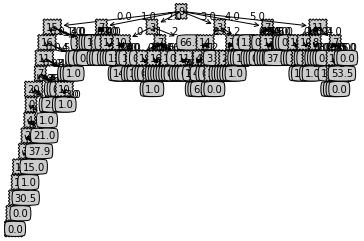

In [5]:
# Exercise 3 My decision tree
# find continues features 
num = pd.Series(range(len(train_features.columns)))
continues_idx = []

for i in list(range(len(train_features.columns))):
    num.values[i]=train_features.iloc[:][i].nunique()  #每种A的个数
    if num.values[i] > 10:
        continues_idx.append(i)


## Initialize a scaler, then apply it to the features
## normalization
#from sklearn.preprocessing import MinMaxScaler
#features = pd.concat([train_features, test_features],axis = 0)
#scaler = MinMaxScaler() # default=(0,1)
#features_log = features.apply(lambda x: np.log(x+1))
#features_norm = scaler.fit_transform(features_log)
#f_rows = features.shape[0]
#train_rows = train_features.shape[0]
#train_features_norm = features_norm[0:train_rows,:]
#train_features_norm = pd.DataFrame(train_features_norm)
#test_features_norm = features_norm[train_rows:,:]
#test_features_norm = pd.DataFrame(test_features_norm)

#确定分枝的主分类
def majority(labels):
    # input parameters are 2 series
    if labels.sum()>(len(labels)/2):
        return 1
    else:
        return 0

# only for 二分类
def calcEnt(features, labels):
    if (labels.sum()==len(labels))|(labels.sum()==0):
        Ent = 0.0
    else:
        p1 = len(features[labels==1])/len(labels)
        p2 = 1-p1
        Ent = -log(p1,2)*p1 - log(p2,2)*p2
    return Ent
    

def chooseBestFeature(features, labels, continues_idx): 
    # calcGain
    Ent = calcEnt(features, labels)
    num_A = features.shape[1]  #属性总数
    gain = pd.Series(range(num_A))
    gain = gain.astype(float)
    points = np.zeros(num_A)
    for i in range(num_A):
        Da = features[features.columns[i]]  #第i个属性列
        DV = Da.value_counts();
        V = len(DV.index)
        if V <= 1:
            gain[i] = -1
            continue
        gain[i] = Ent        
        if features.columns[i] not in continues_idx: 
            # 离散
            for v in range(V):
                Dv = features[Da==DV.index[v]]
                label_v = labels[Da==DV.index[v]]
                gain[i] = gain[i]-DV.values[v]/len(Da)*calcEnt(Dv,label_v)
        else:
            # 连续
            DV = DV.sort_index()
            gain_T = np.zeros(V-1)
            T = np.zeros(V-1)
            m = 0
            for v in range(V-2):                
                T[v] = (DV.index[v]+DV.index[v+1])/2
                Dv = features[Da>=T[v]]
                label_v = labels[Da>=T[v]]
                m = m+DV.values[v]                
                gain_T[v] = gain[i]-(1-m/len(Da))*calcEnt(Dv,label_v)
                Dv = features[Da<T[v]]
                label_v = labels[Da<T[v]]
                gain_T[v] = gain_T[v]-m/len(Da)*calcEnt(Dv,label_v)
            gain[i] = gain_T.max()
            t = T[np.where(gain_T==gain[i])[0][0]] #最优划分点
            points[i] = t
    gain_sort = gain.sort_values(ascending=False)
    ind = gain_sort.index[0]
#    if len(features[features.columns[ind]].value_counts().index)<10:
    if features.columns[ind] not in continues_idx:
        # 离散
        return features.columns[ind], np.NaN   #math.isnan(t)
    else:
        # 连续
        return features.columns[ind], points[ind]
#    return gain_sort.index[0], points #points[gain_sort.index[0]]
    
#[ind,t]=chooseBestFeature(train_features,train_labels)

#对给定的数据集的指定特征的分类值进行分类
def splitFeatures_discrete(features, bestfeat, value, labels):
    # 离散
    bb = features[bestfeat] == value
    new_features = features[bb]
    new_labels = labels[bb]
    del new_features[bestfeat]
    return new_features, new_labels
    
def splitFeatures_continues(features, bestfeat, t, labels):
    bb0 = features[bestfeat]<t
    bb1 = features[bestfeat]>=t
    new_features0 = features[bb0]
    new_labels0 = labels[bb0]
    new_features1 = features[bb1]
    new_labels1 = labels[bb1]
    del new_features0[bestfeat]
    del new_features1[bestfeat]
    return new_features0, new_features1, new_labels0, new_labels1
    
def treeGenerate(features, labels, continues_idx):
#    classlist = list(labels)
    
    # 当前结点包含的样本全属于同一类别
    if labels.nunique() == 1:        
        return labels.values[0]
    
    # 只有1种变量时
    if len(features.columns) == 1:
        return majority(labels)
    
    B = True;
    for i in list(range(len(features.columns))):
        if features[features.columns[i]].nunique() != 1:
            B = False
            break
        else:
            B = True & B
    if B == True:
        return majority(labels)
    
#    print (len(features.columns))
#    if len(features.columns) == 3:
#        ll = 1

        
    # 选择最优划分属性
    [bestfeat, t] = chooseBestFeature(features,labels,continues_idx)  #key
    mytree = {bestfeat: {}}
    
    leaf = set(features[bestfeat])
    
    if bestfeat not in continues_idx:
        # 离散
        for value in leaf:
            [newf, newl]=splitFeatures_discrete(features, bestfeat, value, labels)
            mytree[bestfeat][value] = treeGenerate(newf, newl,continues_idx)
            
    else:
        # 连续
        [f0, f1, l0, l1] = splitFeatures_continues(features, bestfeat, t, labels)
        mytree[bestfeat][0] = treeGenerate(f0,l0,continues_idx)
        mytree[bestfeat][1] = treeGenerate(f1,l1,continues_idx)
        mytree[bestfeat][2] = t
        
    return mytree

def applyTree(test, mytree, continues_idx):    
    if type(mytree) != dict:
#        print("result is :", mytree)
        return mytree
    else:
        for key in mytree:   
            if type(mytree[key]) != dict:
#                print(mytree[key])
                return mytree[key]
            if key in continues_idx:
                # 连续 Continues
                t = mytree[key][2]
                if test.iloc[0][key]<t:
                    subtree = mytree[key][0]
                else:
                    subtree = mytree[key][1]
            else:
                # 离散 Discrete
                if test.iloc[0][key] in mytree[key].keys():
                    subtree = mytree[key][test.iloc[0][key]]
                else:
                    mindis = 100; vv = 0;
                    for v in mytree[key].keys():
                        if mindis > abs(v-test.iloc[0][key]):
                            mindis = abs(v-test.iloc[0][key])
                            vv = v
                    subtree = mytree[key][vv]
    #            if type(subtree) != dict:
    #                return subtree
            result = applyTree(test_features, subtree, continues_idx)
            break
    return result   
 
mytree = treeGenerate(train_features,train_labels,continues_idx)
my_test_result = []
for i in test_features.index:
    test = test_features.iloc[[i]]
    r = applyTree(test,mytree,continues_idx)
    my_test_result.append(r)
    
import plotDTree as pdt
pdt.createPlot(mytree)


In [3]:
# Exercise 4
def calc_APR(true_value, predict_value):
    # inputs are lists
    TP = 0; FP = 0; FN = 0; A = 0;
    for i in range(len(true_value)):
        if (true_value[i] == 1) & (predict_value[i] == 1):
            TP += 1
        if (true_value[i] == 0) & (predict_value[i] == 1):
            FP += 1
        if (true_value[i] == 1) & (predict_value[i] == 0):
            FN += 1
        if true_value[i] == predict_value[i]:
            A += 1
    A = A/len(true_value)
    P = TP/(TP+FP)
    R = TP/(TP+FN)
    return A, P, R

def calc_Fb_score(P, R, beta):
    F = (1+beta**2)*P*R/((beta**2)*P+R)
    return F

test_labels = list(test_labels)
sk_test_result = list(sk_test_result)
[sk_A, sk_P, sk_R] = calc_APR(test_labels, sk_test_result)
[my_A, my_P, my_R] = calc_APR(test_labels, my_test_result)
sk_F = calc_Fb_score(sk_P, sk_R,0.5)
my_F = calc_Fb_score(my_P, my_R,0.5)
print('True labels: ', test_labels)
print('SK results:  ', sk_test_result, 'Accuracy is: %.3f' % sk_A, 'Precision is:', sk_P, 'Recall is:', sk_R, 'F_score is %.3f' % sk_F)
print('My results:  ', my_test_result, 'Accuracy is: %.3f' % my_A, 'Precision is:', my_P, 'Recall is:', my_R, 'F_score is %.3f' % my_F)


True labels:  [1, 1, 0]
SK results:   [0.0, 1.0, 1.0] Accuracy is: 0.333 Precision is: 0.5 Recall is: 0.5 F_score is 0.500
My results:   [1.0, 0.0, 0.0] Accuracy is: 0.667 Precision is: 1.0 Recall is: 0.5 F_score is 0.833
